#### Creating a model for the https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification dataset.

In [40]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Initial setup for all models.

In [41]:
import sys
import os
import random

import so_ml_tools as soml

import tensorflow as tf
import keras as ks
import pandas as pd
import numpy as np
import opendatasets as od

import tensorflow_hub as hub

from keras import Model
from keras import layers
from keras import losses
from keras import optimizers

### Download Kaggle Card Image Dataset

In [42]:
od.download_kaggle_dataset(dataset_url="https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/download?datasetVersionNumber=2", data_dir="./data")

Skipping, found downloaded files in "./data/cards-image-datasetclassification" (use force=True to force download)


### Inspect Dataset

In [43]:
# List the contents of the ./data directory
!ls ./data

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards-image-datasetclassification


In [44]:
# List the contents of the ./data/cards-image-datasetclassification directory
!ls ./data/cards-image-datasetclassification

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards.csv  test  train	valid


In [45]:
# Delete the two saved models
!rm ./data/cards-image-datasetclassification/*.h5
!ls ./data/cards-image-datasetclassification

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
rm: cannot remove './data/cards-image-datasetclassification/*.h5': No such file or directory
/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards.csv  test  train	valid


In [46]:
TRAIN_DIR = './data/cards-image-datasetclassification/train'
TEST_DIR = './data/cards-image-datasetclassification/test'
VALID_DIR = './data/cards-image-datasetclassification/valid'

In [47]:
soml.util.io.list_dir_summary(folder=TRAIN_DIR)

There are 53 directories, and 0 in ./data/cards-image-datasetclassification/train
There are 0 directories, and 152 in ./data/cards-image-datasetclassification/train/six of clubs
There are 0 directories, and 128 in ./data/cards-image-datasetclassification/train/king of clubs
There are 0 directories, and 161 in ./data/cards-image-datasetclassification/train/queen of clubs
There are 0 directories, and 129 in ./data/cards-image-datasetclassification/train/nine of diamonds
There are 0 directories, and 139 in ./data/cards-image-datasetclassification/train/six of diamonds
There are 0 directories, and 139 in ./data/cards-image-datasetclassification/train/queen of hearts
There are 0 directories, and 151 in ./data/cards-image-datasetclassification/train/ten of diamonds
There are 0 directories, and 151 in ./data/cards-image-datasetclassification/train/king of spades
There are 0 directories, and 126 in ./data/cards-image-datasetclassification/train/three of clubs
There are 0 directories, and 157 i

### Visualize some sample data

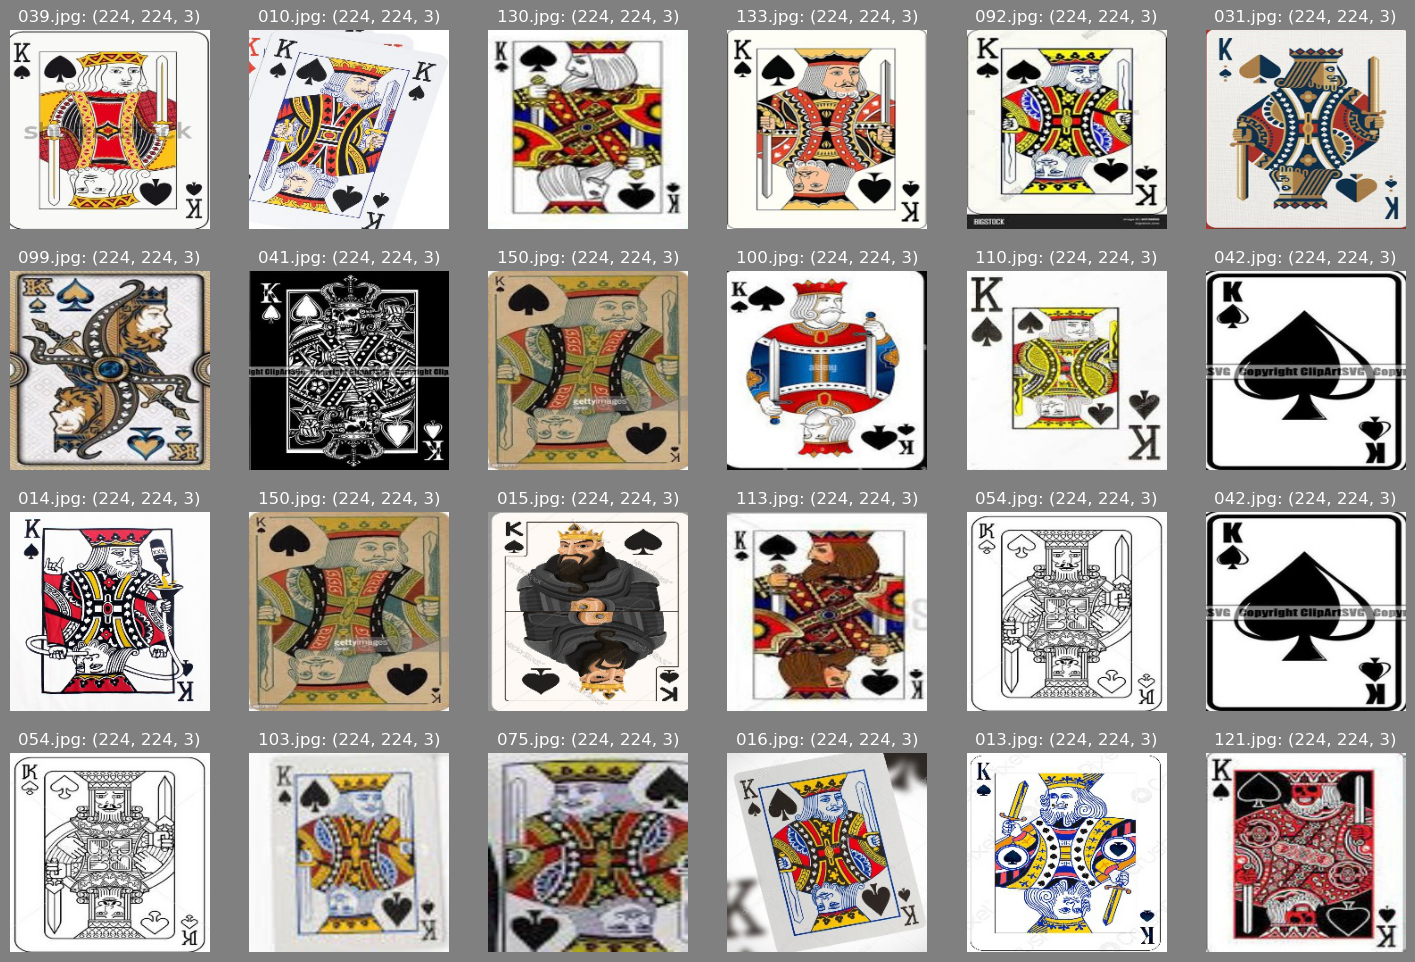

In [48]:
soml.data.image.show_random_image_from_disk(target_dir=TRAIN_DIR, target_class='king of spades')

# Create EfficientNetB0 Model

More details about EfficientNet can be found here:

https://paperswithcode.com/method/efficientnet

### Create datasets

In [49]:
# Set image shape back to 224x224 since the EfficientNetB0 model is based upon this size.
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

# Because we changed the image size we will also need to reload the datasets.
train_dataset = soml.data.loader.load_image_dataset_from_directory(directory=TRAIN_DIR, image_size=IMG_SHAPE, batch_size=BATCH_SIZE)
test_dataset = soml.data.loader.load_image_dataset_from_directory(directory=TEST_DIR, image_size=IMG_SHAPE, batch_size=BATCH_SIZE)
valid_dataset = soml.data.loader.load_image_dataset_from_directory(directory=VALID_DIR, image_size=IMG_SHAPE, batch_size=BATCH_SIZE, shuffle=False)

train_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_shuffling(dataset=soml.tf.dataset.add_caching(dataset=train_dataset)))
test_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_shuffling(dataset=soml.tf.dataset.add_caching(dataset=test_dataset)))
valid_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_caching(dataset=valid_dataset))

print('\nClass-names:')
class_names = soml.tf.dataset.get_class_names(dataset=train_dataset)
class_names[:10]

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
WARN: Dataset is already shuffled.
Buffer size for shuffle has been set to 1000
WARN: Dataset is already prefetched.
WARN: Dataset is already shuffled.
Buffer size for shuffle has been set to 1000
WARN: Dataset is already prefetched.
WARN: Dataset is already prefetched.

Class-names:


['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds']

In [50]:
soml.tf.dataset.describe_pipeline(dataset=train_dataset)

_PrefetchDataset -> _ShuffleDataset -> CacheDataset -> _BatchDataset -> _ShuffleDataset -> _PrefetchDataset -> _ZipDataset

### Perform feature extraction

In [51]:
# Create the EfficientNetB0 base model
efficientnetb0_base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
efficientnetb0_base_model.trainable = False

input_layer = ks.layers.Input(shape=IMG_SHAPE + (3,), name='input_layer')
x = efficientnetb0_base_model(input_layer, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output_layer = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)

efficientnetb0_model = tf.keras.Model(input_layer, output_layer)

# 9. Compile the model
efficientnetb0_model.compile(loss=ks.losses.CategoricalCrossentropy(),
                optimizer=ks.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [52]:
soml.tf.model.inspect.list_model(model=efficientnetb0_model, recursive=False)

row   | name (type)                                     | dtype   | policy  | trainable | output shape             | Total Param # | Trainable Param # | Non-trainable Param #
0     | input_layer            (InputLayer            ) | float32 | float32 | True      | [(None, 224, 224, 3)]    | 0             | 0                 | 0                    
1     | efficientnetv2-b0      (Functional            ) | float32 | float32 | False     | (None, None, None, 1280) | 5,919,312     | 0                 | 5,919,312            
2     | global_average_pooling (GlobalAveragePooling2D) | float32 | float32 | True      | (None, 1280)             | 0             | 0                 | 0                    
3     | dense_3                (Dense                 ) | float32 | float32 | True      | (None, 64)               | 81,984        | 81,984            | 0                    
4     | batch_normalization_3  (BatchNormalization    ) | float32 | float32 | True      | (None, 64)               | 256     

In [53]:
reduce_lr_on_plateau_callback = soml.tf.fit.callback.reduce_lr_on_plateau_callback()
early_stopping_callback = soml.tf.fit.callback.early_stopping_callback();
checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name='efficientnetb0_feature_extraction', file_name='./best-weights.hdf5', verbose=0)

efficientnetb0_history_feature_extraction_history = efficientnetb0_model.fit(train_dataset,
                                                  steps_per_epoch=len(train_dataset),
                                                  epochs=10,
                                                  validation_data=test_dataset,
                                                  validation_steps=len(test_dataset),
                                                  callbacks=[reduce_lr_on_plateau_callback, early_stopping_callback, checkpoint_callback])

Epoch 1/10
239/239 [==============================] - 6s 12ms/step - loss: 3.8826 - accuracy: 0.0779 - val_loss: 3.4975 - val_accuracy: 0.0868 - lr: 1.0000e-04
Epoch 2/10
239/239 [==============================] - 2s 8ms/step - loss: 3.1837 - accuracy: 0.1901 - val_loss: 3.0652 - val_accuracy: 0.1887 - lr: 1.0000e-04
Epoch 3/10
239/239 [==============================] - 2s 8ms/step - loss: 2.8024 - accuracy: 0.2756 - val_loss: 2.7856 - val_accuracy: 0.2528 - lr: 1.0000e-04
Epoch 4/10
239/239 [==============================] - 2s 8ms/step - loss: 2.5288 - accuracy: 0.3514 - val_loss: 2.5559 - val_accuracy: 0.3094 - lr: 1.0000e-04
Epoch 5/10
239/239 [==============================] - 2s 8ms/step - loss: 2.3110 - accuracy: 0.4117 - val_loss: 2.3938 - val_accuracy: 0.3434 - lr: 1.0000e-04
Epoch 6/10
239/239 [==============================] - 2s 8ms/step - loss: 2.1283 - accuracy: 0.4715 - val_loss: 2.2620 - val_accuracy: 0.3698 - lr: 1.0000e-04
Epoch 7/10
239/239 [=========================

### Set last 40 layers to trainable.

In [54]:
# Recompile the model with the default learning rate.
efficientnetb0_model.compile(loss=ks.losses.CategoricalCrossentropy(),
                optimizer=ks.optimizers.Adam(),
                metrics=["accuracy"])

# Load weights after recompile, since recompile sets all weights to random.
soml.tf.model.io.load_weights(model=efficientnetb0_model, filepath='./checkpoints/efficientnetb0_feature_extraction/best-weights.hdf5')

In [55]:
efficientnetb0_base_model.trainable = True
soml.tf.model.layer.set_trainable_on_layers(model=efficientnetb0_base_model, trainable=False)
soml.tf.model.layer.set_trainable_on_last_n_layers(model=efficientnetb0_base_model, n=40, trainable=True)
soml.tf.model.inspect.list_model(model=efficientnetb0_model, recursive=False)

row   | name (type)                                     | dtype   | policy  | trainable | output shape             | Total Param # | Trainable Param # | Non-trainable Param #
0     | input_layer            (InputLayer            ) | float32 | float32 | True      | [(None, 224, 224, 3)]    | 0             | 0                 | 0                    
1     | efficientnetv2-b0      (Functional            ) | float32 | float32 | True      | (None, None, None, 1280) | 5,919,312     | 1,720,720         | 4,198,592            
2     | global_average_pooling (GlobalAveragePooling2D) | float32 | float32 | True      | (None, 1280)             | 0             | 0                 | 0                    
3     | dense_3                (Dense                 ) | float32 | float32 | True      | (None, 64)               | 81,984        | 81,984            | 0                    
4     | batch_normalization_3  (BatchNormalization    ) | float32 | float32 | True      | (None, 64)               | 256     

In [56]:
efficientnetb0_history = efficientnetb0_model.fit(train_dataset,
                                                  steps_per_epoch=len(train_dataset),
                                                  epochs=50,
                                                  validation_data=test_dataset,
                                                  validation_steps=len(test_dataset),
                                                  initial_epoch=efficientnetb0_history_feature_extraction_history.epoch[-1] + 1,
                                                  callbacks=[reduce_lr_on_plateau_callback, early_stopping_callback])

Epoch 11/50
239/239 [==============================] - 6s 11ms/step - loss: 1.5526 - accuracy: 0.5889 - val_loss: 1.5698 - val_accuracy: 0.5434 - lr: 0.0010
Epoch 12/50
239/239 [==============================] - 2s 8ms/step - loss: 1.0611 - accuracy: 0.7214 - val_loss: 1.3889 - val_accuracy: 0.5962 - lr: 0.0010
Epoch 13/50
239/239 [==============================] - 2s 8ms/step - loss: 0.7502 - accuracy: 0.8056 - val_loss: 1.3531 - val_accuracy: 0.5887 - lr: 0.0010
Epoch 14/50
239/239 [==============================] - 2s 8ms/step - loss: 0.5445 - accuracy: 0.8645 - val_loss: 1.4997 - val_accuracy: 0.5623 - lr: 0.0010
Epoch 15/50
239/239 [==============================] - 2s 8ms/step - loss: 0.3797 - accuracy: 0.9130 - val_loss: 1.4163 - val_accuracy: 0.6113 - lr: 0.0010
Epoch 16/50
239/239 [==============================] - 2s 8ms/step - loss: 0.2706 - accuracy: 0.9437 - val_loss: 1.3784 - val_accuracy: 0.6679 - lr: 0.0010
Epoch 17/50
236/239 [============================>.] - ETA: 0s 

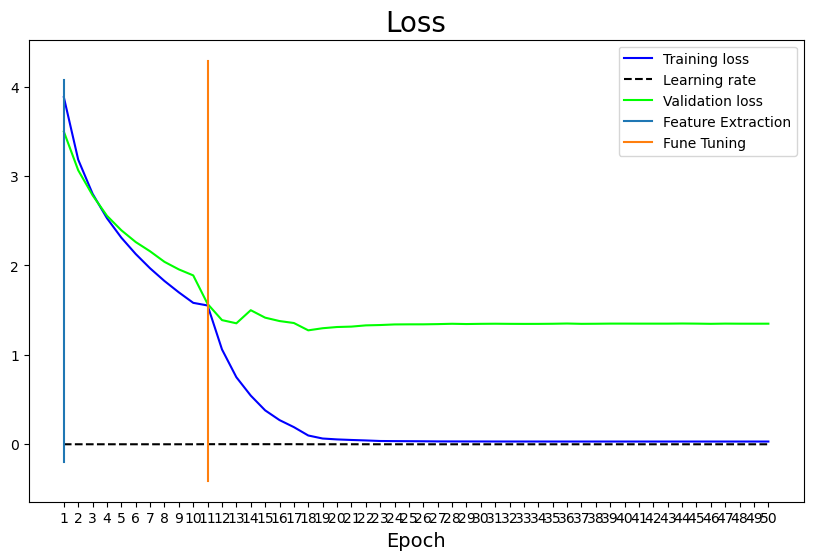

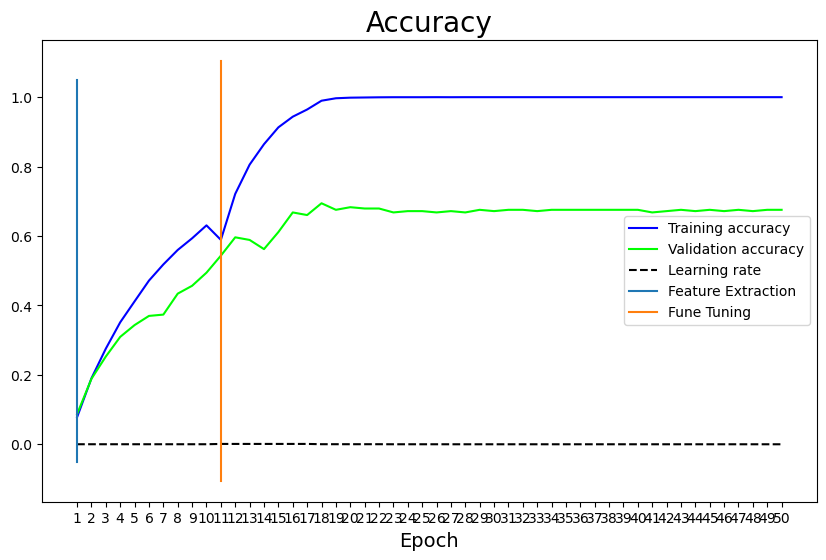

In [57]:
soml.tf.model.plot.plot_consecutive_histories(histories=[efficientnetb0_history_feature_extraction_history, efficientnetb0_history], labels=['Feature Extraction', 'Fune Tuning'])

In [61]:
y_prob = efficientnetb0_model.predict(valid_dataset)
len(y_prob)

9/9 [==============================] - 0s 6ms/step


265

In [62]:
y_true = soml.tf.dataset.get_labels(dataset=valid_dataset)
len(y_true)

265

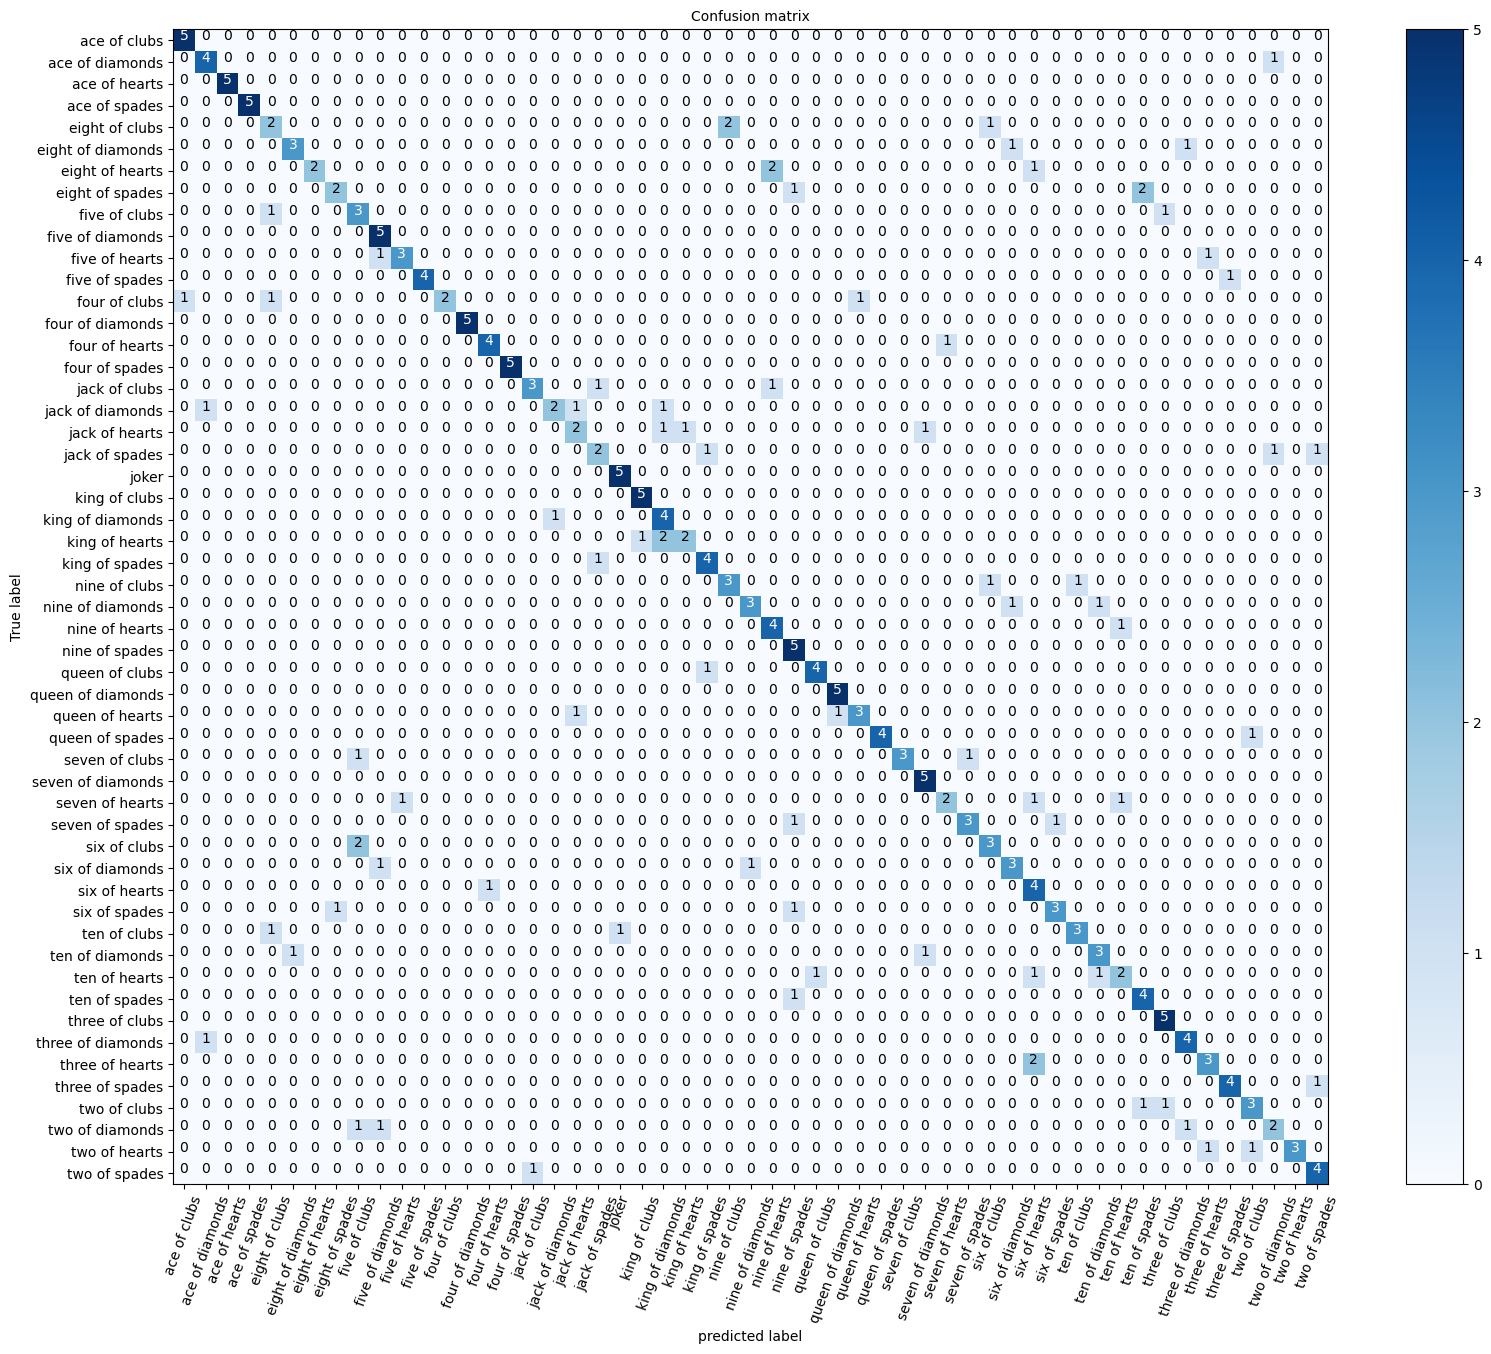

In [64]:
soml.evaluate.plot.confusion_matrix(y_true=y_true, y_prob=y_prob, class_names=class_names, figsize=(20, 15))

In [66]:
soml.evaluate.analyze.quality_metrics(y_true=y_true, y_prob=y_prob)

,accuracy,f1-score,precision,recall
0,69.811321,0.691463,0.720597,0.698113
